# Self-Organizing Maps (SOMs) Notebook

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**
**Updated for ATOC5860 by Jennifer E. Kay (University of Colorado)**

Last updated: March 23, 2022

This Notebook reads in data from a single CESM2-LE member for a user-specified variable. It subsets the data by a user-specified coastal region around Antarctica. Then it loops through a series of SOM hyperparameters to train a number of SOMs. There is also code to evaluate the SOM robustness.

Before starting, do the following steps: 
1) Install anaconda.  If on NCAR super computers - use miniconda3, go to https://github.com/NCAR/ncar-python-tutorial#step-2-install-miniconda-and-create-environments and complete steps 1 through 3. **You only do this once.**

2) Create a python environment named ``som_env``. 

    Log into cheyenne and create your som environment. **You only do this once.**
    > conda create --name som_env python=3.7.9
    
    If on NCAR supercomputer, the environment will be located here: /glade/work/USER/miniconda3/envs/som_env
    
    Now, if you have to install packages you do the following from the cheyenne command line:
    > conda activate antarctica_som_env 

    Then install packages and defined versions from the command line.
    > conda install ipykernel
    
    > conda install numpy=1.17.2
    
    > conda install cftime=1.0.3.4

    > conda install matplotlib=3.1.1

    > conda install pandas=0.25.1

    > conda install xarray=0.16.1

    > conda install netCDF4  (original instructions had "conda install netCDF4=1.5.1.2", but this didn't work for JEK)

    > conda install scipy=1.3.1
    
    > conda install cartopy (added by JEK)

    > conda install jupyter (added by JEK)
    
    > conda install -c conda-forge jupyterlab (added by JEK)
    
    Install MiniSom. Clone the git repository at your desired location on glade. We suggest your work or home directory. Where it is located won’t matter for running your notebook since we will be installing it within the python environment.

    > git clone https://github.com/JustGlowing/minisom.git

    Then run the following command from within the minisom directory. There should be a setup.py file.

    > python setup.py install

    Now that you are done installing packages to you python environment named ``som_env``, you can deactivate it from the command line.

    > conda deactivate

    That’s it for installing! Hopefully this all worked okay.

3) Make sure that when you open your notebook you activate your conda environment containing the packages needed for this work ``som_env`` within the drop down menu located in the top right of this notebook.

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from datetime import timedelta
from itertools import product
import pickle
import sammon

### Set user-specified information

In [3]:
# USER SPECIFIED DATA CHOICES

# choose what variable to train on with daily data
var_in = 'aice_d'
# set where the data are located
#data_root= '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/day_1/'
data_root = 'SOM_data/'
# select a single CESM2-LE member
ens_name='b.e21.BHISTcmip6.f09_g17.LE2-1001.001'

# set path for masks
data_mask = './'
mask_name = 'antarctic_ocean_masks_2'

In [4]:
# Choose which region to train SOM on

# these values are needed for choosing training area and then plotting
sector_short = 'Ross'
mask_in = 'Ross_mask'
lat_max = -72
lat_min = -85
lon_max = 200
lon_min = 160
lon_avg = 190

# select years and months to subset data
# select just winter: JAS (7,8,9) 
mm_st = 7
mm_ed = 9
# select just 1900-1950 (commented out by JEK)
#yy_st = 1900
#yy_ed = 1950

## Section 1: Load and get correct training data

### Load in the data

In [5]:
# open multiple datasets and automatically combine if there are no conflicts
#ds = xr.open_mfdataset(data_root+var_in+'/'+ens_name+'.cice.h1.'+var_in+'.*.nc', combine='by_coords')

ds = xr.open_dataset(data_root+var_in+'/'+ 'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cice.h1.aice_d.20000102-20100101.nc')

# Shifting time by 1 day because CESM saves data at the end of a time period
ds = ds.assign_coords(time=ds.coords["time"]-timedelta(days=1))

ds

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, nc: 5, nkice: 8, nksnow: 3, nkbio: 5,
                  nvertices: 4, time: 3650, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 ...
    TLAT         (nj, ni) float32 ...
    ULON         (nj, ni) float32 ...
    ULAT         (nj, ni) float32 ...
  * time         (time) object 2000-01-01 00:00:00 ... 2009-12-31 00:00:00
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (nc) float32 ...
    VGRDi        (nkice) float32 ...
    VGRDs        (nksnow) float32 ...
    VGRDb        (nkbio) float32 ...
    tmask        (nj, ni) float32 ...
    tarea        (nj, ni) float32 ...
    ...           ...
    lont_bounds  (nj, ni, nvertices) float32 ...
    latt_bounds  (nj, ni, nvertices) float32 ...
    lonu_bounds  (nj, ni, nvertices) float32 ...
    latu_bounds  (nj, ni, nvertices) float32 ...
    time_bounds  (time, d2) object ...
    aice_d       (time, nj, ni) float32 ...
Attributes:
    title:             b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20000102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2020-02-11 at 18:07
    io_flavor:         io_pio

In [6]:
# select just the variable we are training on to keep
ds_ice = ds[var_in]

# subset by months
ds_ice = ds_ice[(ds_ice.coords['time.month']>=mm_st)&(ds_ice.coords['time.month']<=mm_ed)]

# subset by years
#ds_ice = ds_ice[(ds_ice.coords['time.year']>=yy_st)&(ds_ice.coords['time.year']<=yy_ed)]

ds_ice

<xarray.DataArray 'aice_d' (time: 920, nj: 384, ni: 320)>
[113049600 values with dtype=float32]
Coordinates:
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
  * time     (time) object 2000-07-01 00:00:00 ... 2009-09-30 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [7]:
# check that the time bounds look correct
ds_ice.time

<xarray.DataArray 'time' (time: 920)>
array([cftime.DatetimeNoLeap(2000, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 7, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 7, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2009, 9, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 9, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 9, 30, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2000-07-01 00:00:00 ... 2009-09-30 00:00:00

### Mask data

In [8]:
# Load in the masking file
#ds_masks = xr.open_mfdataset(data_mask+mask_name+'.nc')
ds_masks = xr.open_dataset(data_mask+mask_name+'.nc')

# create array for mask
# need to use the intersection of masks for a particular sector (e.g. Ross_mask) with the coastal mask (coast_mask)
ds_mask = xr.where((ds_masks[mask_in]==1)&(ds_masks['coast_mask']==1),ds_masks['coast_mask'],0)

# mask the ice data with the regional, coastal mask
ds_ice_masked = xr.where(ds_mask.values==1,ds_ice,-999.999)

/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'sh_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'socn_mask' has multiple fill values {0, -2147483647}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'Wed_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'Ross_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/kado8663

In [9]:
# make smaller array where we ignore all global data - this makes it easier to plot
ds_ice_masked_subset = ds_ice_masked.where(
                             (ds['TLAT']<lat_max) & (ds['TLAT']>lat_min) & \
                             (ds['TLON']>lon_min) & (ds['TLON']<lon_max), 
                             drop=True) 

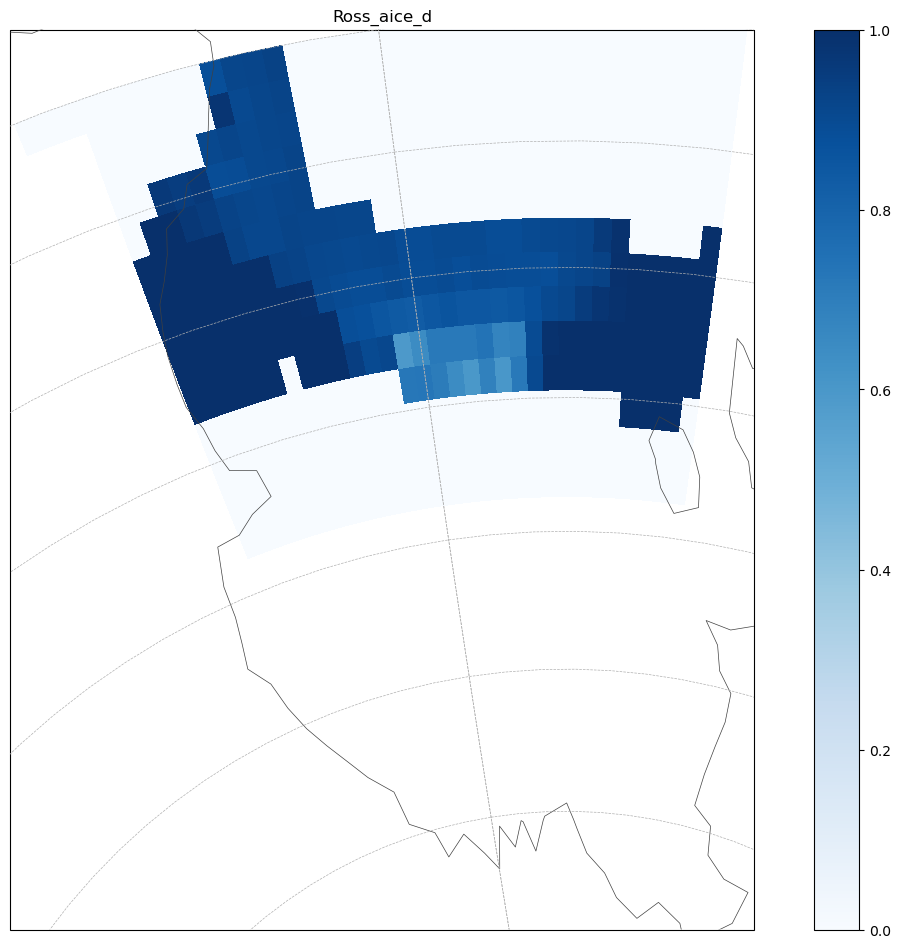

In [10]:
# Check that we've selected the correct area for the training data - use pcolor

# set labeling info:
fout = sector_short+'_'+var_in

# Choose just one timestep
data = ds_ice_masked_subset.isel(time=0)

# create figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes([0.,0.,1.,1.], projection=ccrs.Stereographic(central_longitude=lon_avg))
# make plot
cs1 = ax.pcolor(     data.coords['TLON'].values,    
                     data.coords['TLAT'].values, 
                     data, 
                     cmap='Blues',vmin=0,vmax=1,
                     transform=ccrs.PlateCarree())
# select some regional boundaries to plot
ax.set_title(fout, fontsize=12)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  
ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# add a colorbar
plt.colorbar(cs1)

plt.show()

# uncomment below to save figure
#plt.savefig(fout+'_1.png', bbox_inches='tight', dpi=200)

/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


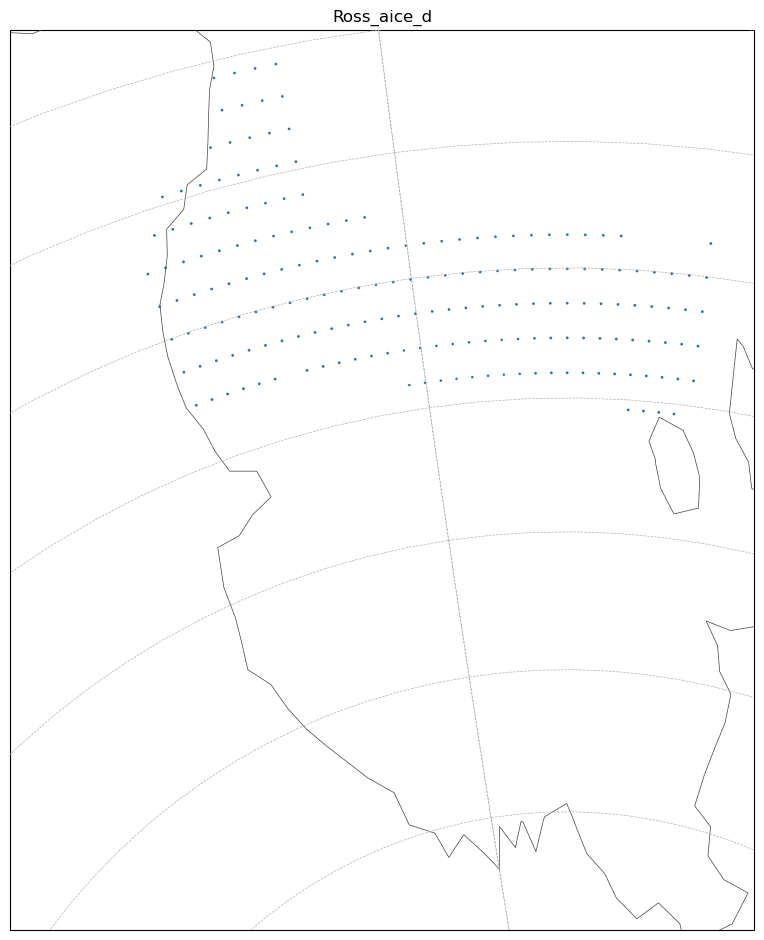

In [11]:
# Check that we've selected the correct area for the training data - use scatter plot to see individual grid points

# set labeling info:
fout = sector_short+'_'+var_in

# Choose just one timestep
data = ds_ice_masked_subset.isel(time=0)

# create figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes([0.,0.,1.,1.], projection=ccrs.Stereographic(central_longitude=lon_avg))
# make plot
cs1 = ax.scatter(    data.coords['TLON'].values,    
                     data.coords['TLAT'].values, 
                     data, 
                     cmap='Blues',vmin=0,vmax=1,
                     transform=ccrs.PlateCarree())
# select some regional boundaries to plot
ax.set_title(fout, fontsize=12)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)  
ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)

plt.show()

# uncomment below to save figure
#plt.savefig(fout+'_2.png', bbox_inches='tight', dpi=200)

In [12]:
# actually load data
ds_ice_masked_subset = ds_ice_masked_subset.load()

In [13]:
%%time
# THIS STEP IS A SLOW ONE
# Flatten into this new shape * prior * to dropping values. otherwise, xarray fills 
# values with NaNs (or other value) to return a 2d shape, which we don't want.
ds_ice_masked_1d = ds_ice_masked.stack(new=("nj","ni"))

# assign object a name (e.g., subset) and drop the data we don't need to minimize size of the array
subset = ds_ice_masked_1d.where(ds_ice_masked_1d!=-999.999, drop=True)

# assign to numpy array object
subsetarray = subset.values

CPU times: user 80.2 ms, sys: 35.2 ms, total: 115 ms
Wall time: 123 ms


In [14]:
# triple check the data dimensions
print(subsetarray.shape)
# confirm there are no NaN values in array for training (should print False if no values)
print(np.isnan(subsetarray).any())

(920, 349)
False


## Section 2: Train the SOM

### Set SOM Hyperparameters we'll test

In [15]:
# set possible grid sizes - these should be equal so the SOM is square and are paired below
# user should try different combinations - e.g. 3x3, 5x5, 9x9
som_grid_rows    = [3]    # (y-axis)
som_grid_columns = [3]    # (x-axis)

# spread of neighborhood function - largest value should be one smaller than som dimension, decrease by one after that
sigma            = [2.0, 1.0, 0.5]
# initial learning rate (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
learning_rate    = [0.005, 0.05, 0.5]
# how many iterations to go through
num_iteration    = [100000, 500000, 1000000]

# for above values, miniSOM will test test a total of 3*3*3 = 27 possible SOMs for this size. 

In [16]:
# creating list of hyperparameters to iterate through
list_of_rows = []
list_of_cols = []
list_of_sigs = []
list_of_lrts = []
list_of_itrs = []

for som_row, som_col in zip(som_grid_rows, som_grid_columns):
    for sig, lr, n_iter in product(sigma, learning_rate, num_iteration):
        list_of_rows.append(som_row)
        list_of_cols.append(som_col)
        list_of_sigs.append(sig)
        list_of_lrts.append(lr)
        list_of_itrs.append(n_iter)

In [17]:
# define a function to normalize data
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [18]:
# actually train som
# this step is slow (think an hour!) because it's training all those combinations and saving the quantization errors

quant_errors = []

random_order = True
verbose = True

# empty csv
our_csv = pd.DataFrame(np.zeros((len(list_of_rows), 6), dtype=int), columns=["n_row", "n_col", "sigma", "lr", "n_iter", "q_error"])

for num_exp, (som_row, som_col, sig, lr, n_iter) in enumerate(zip(list_of_rows,list_of_cols,list_of_sigs,list_of_lrts,list_of_itrs)):
    # print out which SOM we are on
    print(num_exp)
    
    # set other attributes required for som training
    input_length = subsetarray.shape[1]      # Total number of points to train on per timestep
    decay_function = asymptotic_decay        # Function that reduces learning_rate and sigma at each iteration
    neighborhood_function = 'gaussian'       # Function that weights the neighborhood of a position in the map
    topology = 'rectangular'                 # Topology of the map; Possible values: 'rectangular', 'hexagonal'
    activation_distance = 'euclidean'        # Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
    random_seed = 1                          # Random seed to use for reproducibility. Using 1.
    random_order = True
    verbose = True
    
    # initialize the SOM    
    som = MiniSom(som_row,som_col,input_length,sig,lr,decay_function,
                  neighborhood_function,topology,activation_distance,random_seed) 
    
    data = normalize_data(subsetarray)  # prob take out
    
    som.pca_weights_init(data)  # Initializes the weights to span the first two principal components
                                # could also try random init: som.random_weights_init(data)
    
    # train the SOM!
    som.train(data,n_iter,random_order,verbose)
    
    print('yay! som training complete')
    
    our_csv.iloc[num_exp] += [som_row, som_col, sig, lr, n_iter, som.quantization_error(data)]
        
    print('on to the next one...')

0
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 7.600362773677457
yay! som training complete
on to the next one...
1
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 7.587867504998604
yay! som training complete
on to the next one...
2
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 7.574871558521165
yay! som training complete
on to the next one...
3
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 7.612292099186384
yay! som training complete
on to the next one...
4
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 7.597425682402956
yay! som training complete
on to the next one...
5
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 7.583927739040443
yay! som training complete
on to the next one...
6
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 7.717109654510036
yay! som training complete
on to the next one...
7
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 7.79803

In [20]:
# save the CSV in case we need it later
fout = 'som_qerror_'+sector_short+'_'+var_in+'_'+str(som_grid_rows[0])+'x'+str(som_grid_columns[0])+'.csv'
our_csv.to_csv(fout)

## Section 3: Evaluate the SOMs

### Plot the qerrors to find lowest

In [21]:
# read in the csv file with all the possible soms
df = pd.read_csv(fout)

In [22]:
# sort values by q_error
sorted_df = df.sort_values(['q_error'])

# grab all the qerrors and make array against which to plot
qerr_all = sorted_df.q_error
xarr_all = np.arange(1,len(qerr_all)+1,1)

# find and save the lowest qerror for top # (1)
top_n = sorted_df.head(1)
bottom_n = sorted_df.tail(1)

In [23]:
# set the training values for this winning combination
qerr = top_n['q_error'].item()
sig = top_n['sigma'].item()
lr = top_n['lr'].item()
n_iter = int(top_n['n_iter'].item())

# set file name based on these combos
fin = 'som_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)

Plotting qerror for som: 3x3


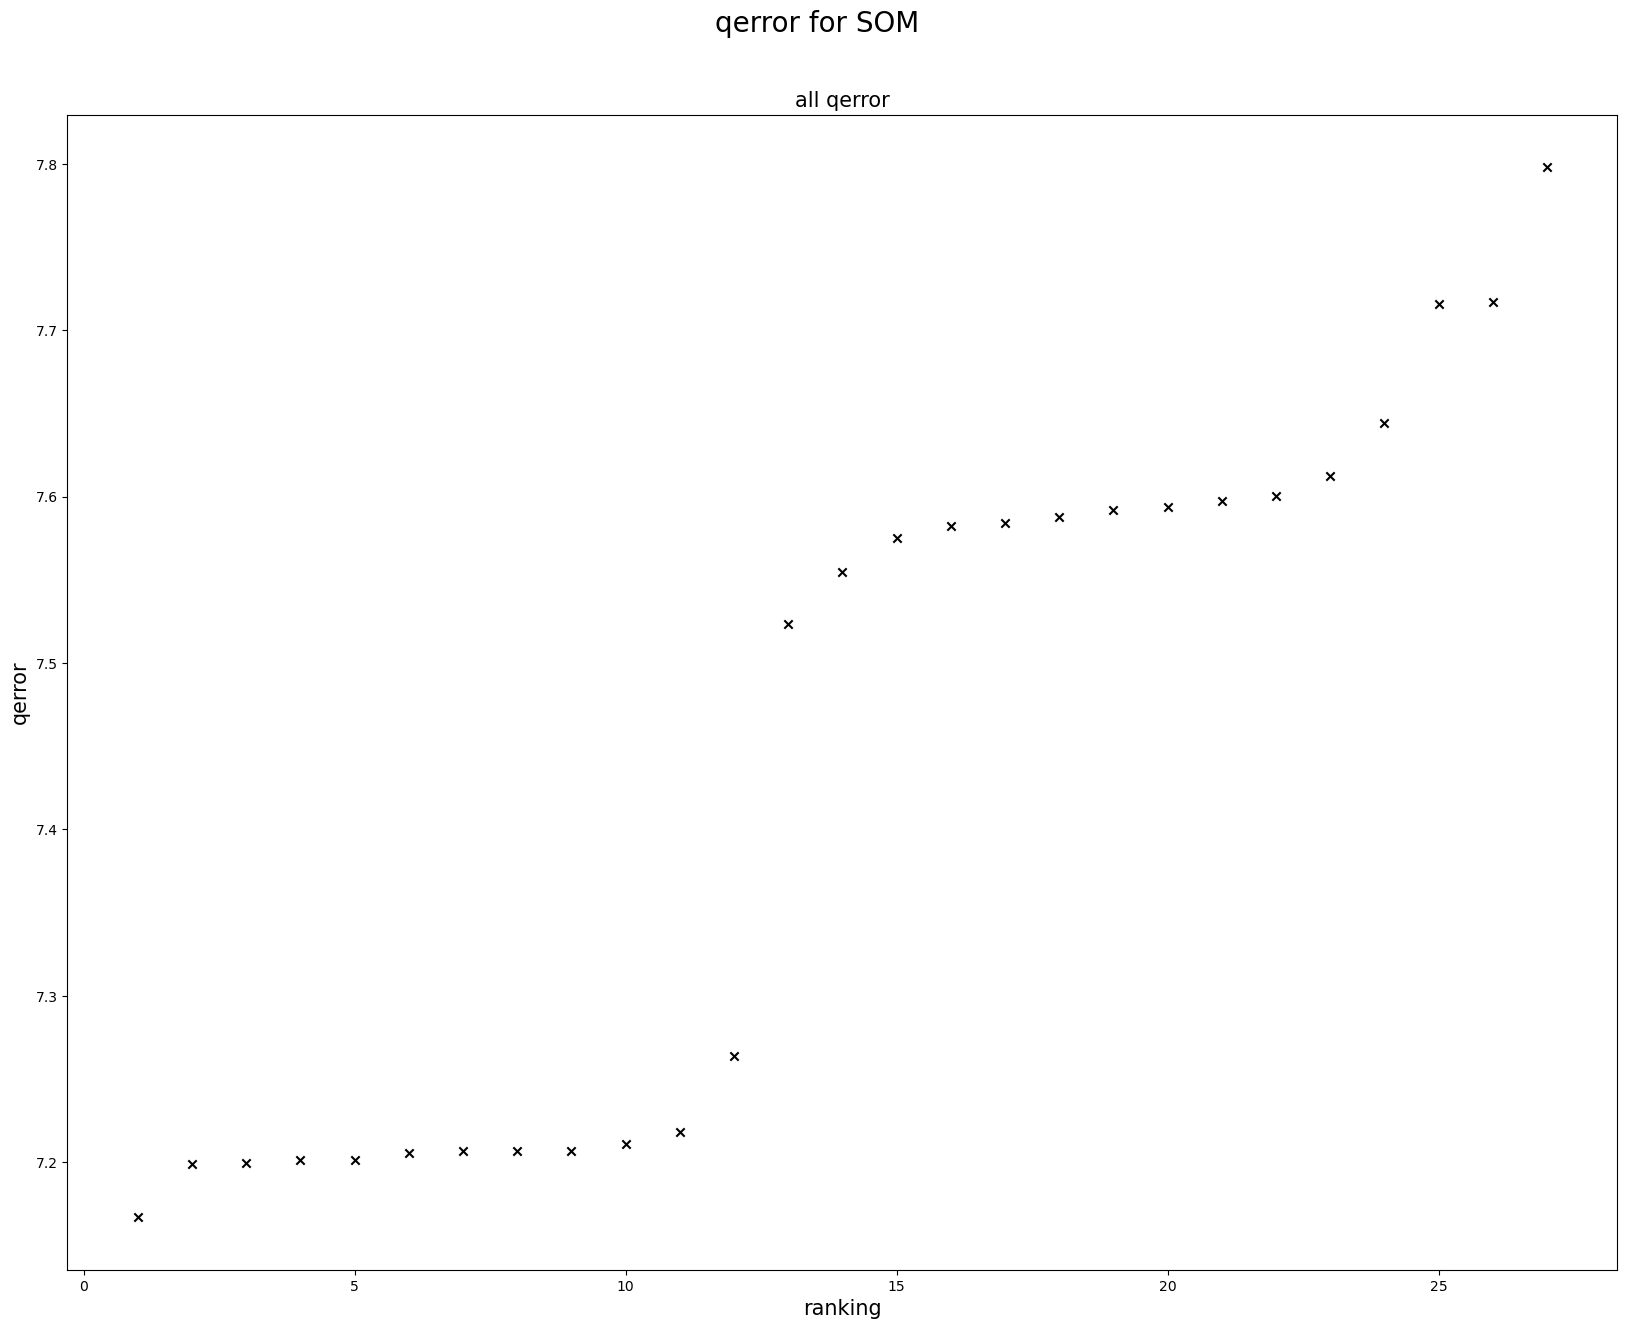

In [24]:
print('Plotting qerror for som: '+str(som_row)+'x'+str(som_col))

# Actually plot figure now
fig = plt.figure(figsize=(20,15))

# plot all SOM qerror
ax = fig.add_subplot(1,1,1)
ax.scatter(xarr_all,qerr_all,marker='x',c='black')
plt.title('all qerror',fontsize=15)
plt.xlabel('ranking',fontsize=15)
plt.ylabel('qerror',fontsize=15)

# Finalize figure and save
fig.suptitle('qerror for SOM',fontsize=20, y=0.95)  
fig.subplots_adjust(hspace=0.3)

plt.show()

# uncomment below to save figure
#plt.savefig('qerrors_all.png', bbox_inches='tight', dpi=200)

### Re-train lowest qerror combination so we can save the SOM and use it to plot more info

In [25]:
print('re-training lowest qerror only')
    
# print the qerror read in. This should match the final qerror after re-training.
print('original qerr = '+str(qerr))

# initialization of SOM
som = MiniSom(
            som_row,
            som_col,
            input_length,
            sig,
            lr,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed) 
# before training, initialize the data
som.pca_weights_init(data) 
# actually train SOM - the quantization error here should match qerr printed above
som.train(
        data,
        n_iter,
        random_order,
        verbose)
    
# save the som as a pickle to analyze later
with open(fin+'.p', 'wb') as outfile:
    pickle.dump(som, outfile)
    

re-training lowest qerror only
original qerr = 7.1668542122961565
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 7.1668542122961565


### Plot sammon map

This shows how "flat" the map is in 2D space. You do NOT want a twisted map.

TolFun exceeded: Optimisation terminated


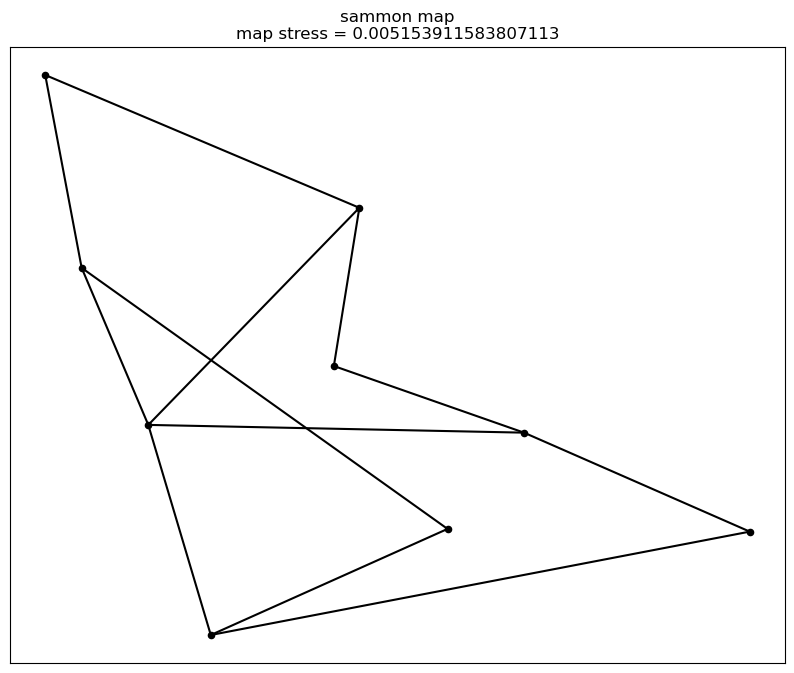

In [26]:
# open pickle
with open(fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

# Calculate sammon coordinates (y) for map and "map stress" (E)
[y,E] = sammon.sammon(som.get_weights().reshape(som_col*som_row, input_length),2,display=1)
# Plot Sammon map nodes
fig = plt.figure(figsize=(10,8))
plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')
# Add lines between nodes
tmp = np.reshape(y,(som_col,som_row,2))
len_x, len_y, len_z = tmp.shape
# add vertical lines
for i in range(len_x-1):
    for j in range(len_y):
        plt.plot(tmp[i:i+2,j,0],tmp[i:i+2,j,1],c='black')
# add horizontal lines
for i in range(len_x):
    for j in range(len_y-1):
        plt.plot(tmp[i,j:j+2,0],tmp[i,j:j+2,1],c='black')    
plt.xticks([])
plt.yticks([])
plt.title(r"sammon map" "\n" r"map stress = "+str(E), fontsize=12)

plt.show()

# uncomment below to save figure
#plt.savefig(fin+'_sammon.png', bbox_inches='tight', dpi=200)

### Plot the node frequencies

This shows you how frequently patterns from the training data mapped to each node

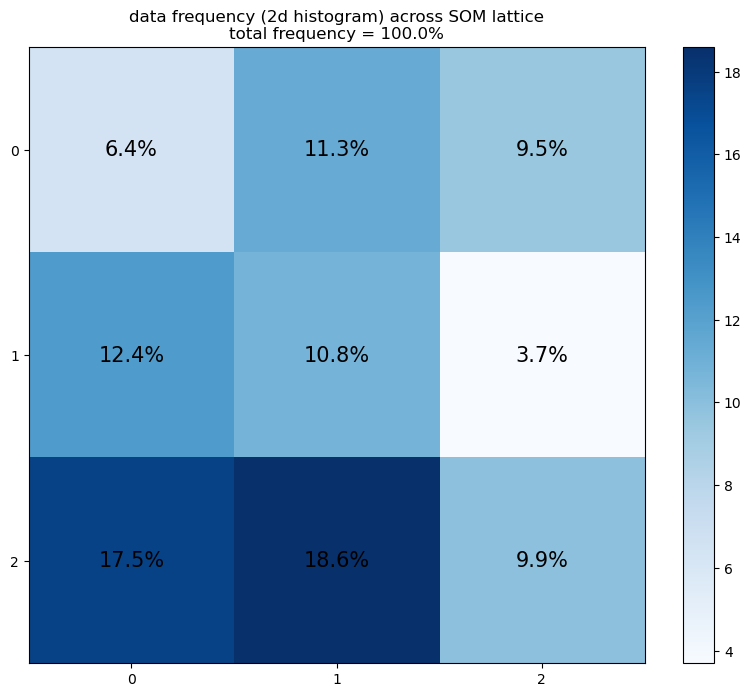

In [27]:
# open pickle
with open(fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# Plot frequencies across SOM lattice
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
im = ax.imshow(frequencies, cmap='Blues')    
# Loop over data dimensions and create text annotations in each cell
len_x, len_y = frequencies.shape
for i in range(len_x):
    for j in range(len_y):
        text = ax.text(j, i, str(round(frequencies[i, j],1))+'%', fontsize=15, ha="center", va="center", color="k")

# Make cosmetic changes
cbar = plt.colorbar(im)
plt.title("data frequency (2d histogram) across SOM lattice" "\n" r"total frequency = "+str(total)+"%", fontsize=12)
plt.xticks(np.arange(0,som_row, 1))
plt.yticks(np.arange(0,som_col, 1))

plt.show()

# uncomment below to save figure
#plt.savefig(fin+'_freq.png', bbox_inches='tight', dpi=200)

### Plot a composite map

This shows you what the average of each node looks like so you can see the patterns the SOM identified"

In [28]:
# grabbing indices from SOM
# open pickle
with open(fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i)

som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


In [29]:
# Grab first node - needed later for TLAT/TLON since that was misbehaving. Ugh
node1 = ds_ice_masked_subset.stack(new=("nj","ni"))[np.array(winmap[som_keys[0]])].unstack().mean(dim="time",skipna=True)

/var/folders/70/pwv0tb2d67g1x48xdyg5cjvr00b8m2/T/ipykernel_6204/3611348609.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_choice = plt.cm.get_cmap('coolwarm')


Making map: 0
Making map: 1
Making map: 2
Making map: 3
Making map: 4
Making map: 5
Making map: 6
Making map: 7
Making map: 8


/Users/kado8663/anaconda3/envs/ATOC5860_NEW/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


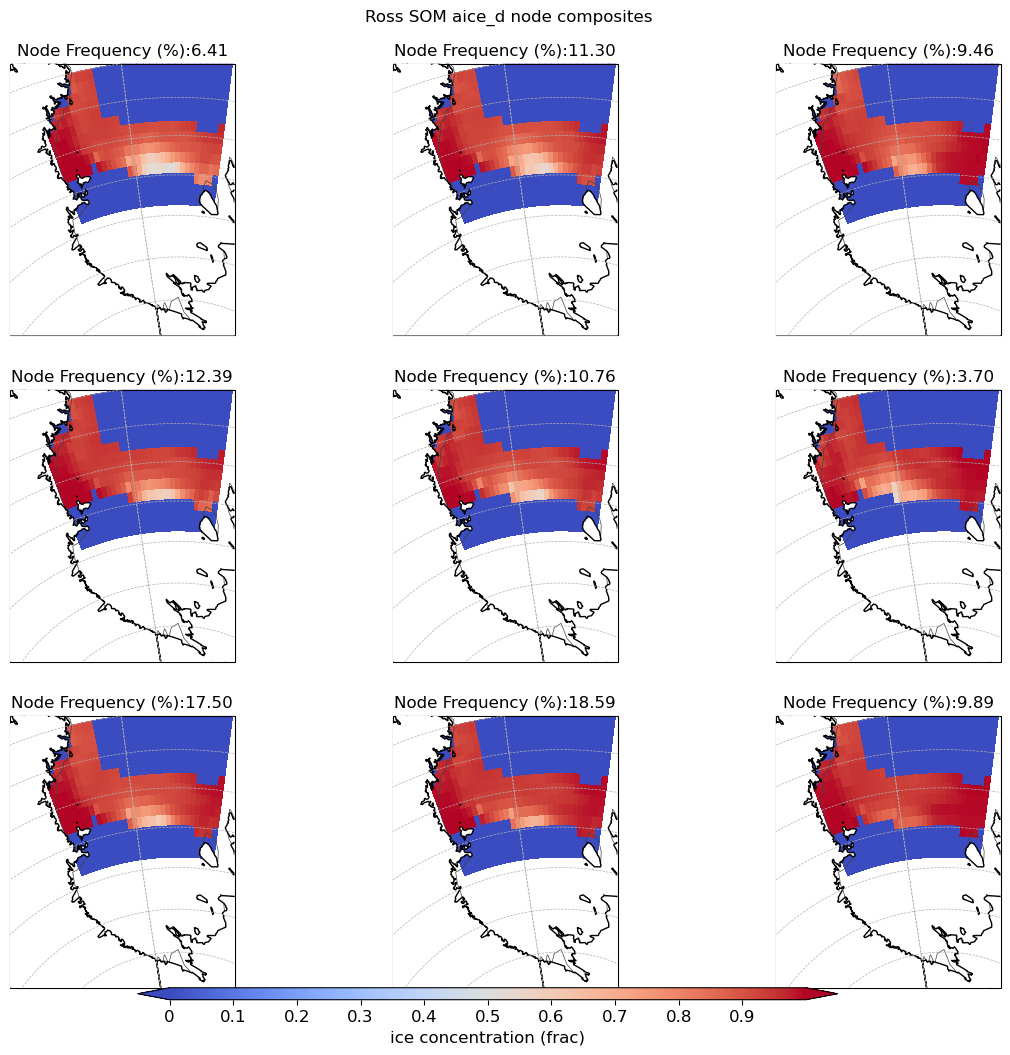

In [30]:
# view all SOM composite maps   (this cell takes a few minutes to run, especially if SOM lattice is large)

# ------------------------

fig, axs = plt.subplots(som_row, som_col, subplot_kw={'projection':ccrs.Stereographic(central_longitude=lon_avg)}, figsize=(14,12))

# set the colors
cmap_choice = plt.cm.get_cmap('coolwarm')
cmap_choice.set_bad(color='white')

# ------------------------

for map_num in range(len(som_keys)):
    print("Making map: "+str(map_num))
    
    # the data for this node
    temp_data = ds_ice_masked_subset.stack(new=("nj", "ni"))[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True).values
    
    # plot
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].pcolor(
                                                              node1.coords['TLON'].values, 
                                                              node1.coords['TLAT'].values, 
                                                              temp_data, 
                                                              #vmin=0, vmax=2, cmap=cmap_choice,   # set vmin and vmax so that all plots are on same scale (for colorbar)
                                                              vmin=0, vmax=1, cmap=cmap_choice,   # set vmin and vmax so that all plots are on same scale (for colorbar)
                                                              transform=ccrs.PlateCarree())

    axs[som_keys[map_num][0],som_keys[map_num][1]].set_extent([lon_min,lon_max,lat_min,lat_max])
    axs[som_keys[map_num][0],som_keys[map_num][1]].coastlines(resolution='110m', color='0.25', linewidth=0.5, zorder=10)
    axs[som_keys[map_num][0],som_keys[map_num][1]].add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
    axs[som_keys[map_num][0],som_keys[map_num][1]].gridlines(linestyle='--', linewidth=0.5, zorder=11)
    
    # plot titles
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title('Node Frequency (%):{:.2f}'.format(frequencies.flatten()[map_num]), fontsize=12)

# ------------------------
    
# figure title
plt.suptitle(sector_short+' SOM '+var_in+' node composites', fontsize=12, x=0.515, y=0.925)

# colorbar stuff
cbar_ax = fig.add_axes([0.25,0.1,0.5,0.01])  # set axis for colorbar e.g., ([x, y, dx, dy])
ticks_1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]     # cb ticks (use same scale as vmin and vmax)
cbar = fig.colorbar(cs, # (from plot loop above, notice we equaled plot to cs -- this passes those attributes to here)
                    cax=cbar_ax, ticks=ticks_1[:],     # plot it
                    orientation='horizontal', extend='both')
cbar.ax.set_xticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] )   # tick labels
cbar.ax.tick_params(labelsize=12)     # tick size
cbar.set_label('ice concentration (frac)', fontsize=12)    # cb label

plt.show()

# uncomment below to save figure
#plt.savefig(fin+'_composites.png', bbox_inches='tight', dpi=200)